# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn import model_selection
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
import optuna


## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [1001]:
df = pd.read_csv('data/bank_fin.csv', sep = ';'

In [1002]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код

dd = df.isna().sum()
print(dd)

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64


### Задание 2

In [1003]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код

print(df['job'].value_counts())

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64


### Задание 3

In [1004]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(lambda x: x[:-2].strip().replace(' ','').replace(',', '.') if x==x else None)
df['balance'] = df['balance'].astype('float')

In [1005]:
df['balance'].mean()

np.float64(1529.1290293615875)

### Задание 4

In [1006]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код

df['balance'] = df['balance'].fillna(df['balance'].median())
df.balance.mean()

np.float64(1526.9360329690019)

### Задание 5

In [1007]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
df['job'] = df['job'].apply(lambda x: x if x != 'unknown' else df['job'].mode()[0])
df['education'] = df['education'].apply(lambda x: x if x != 'unknown' else df['education'].mode()[0])



In [1008]:
df[(df['job'] == df['job'].mode()[0]) & (df['education'] == df['education'].mode()[0])]['balance'].mean()

np.float64(1598.8829787234042)

### Задание 6

In [1009]:
# удалите все выбросы для признака balance
# ваш код
def bounds(feature):
    q1 = feature.quantile(0.25)
    q3 = feature.quantile(0.75)
    lower_bound = q1 - 1.5*(q3-q1)
    upper_bound = q3 + 1.5*(q3-q1)
    return upper_bound, lower_bound

upper_bound, lower_bound = bounds(df['balance'])

print(f'Upper bound is {upper_bound}')
print(f'Lower bound is {lower_bound}')

df = df[(lower_bound <= df['balance']) & (df['balance'] <= upper_bound)]
df.shape[0]

Upper bound is 4063.0
Lower bound is -2241.0


10105

## Часть 2:  Разведывательный анализ

### Задание 1

Amount of people who opened deposit: 4681
Amount of people who didn't open deposit: 5424


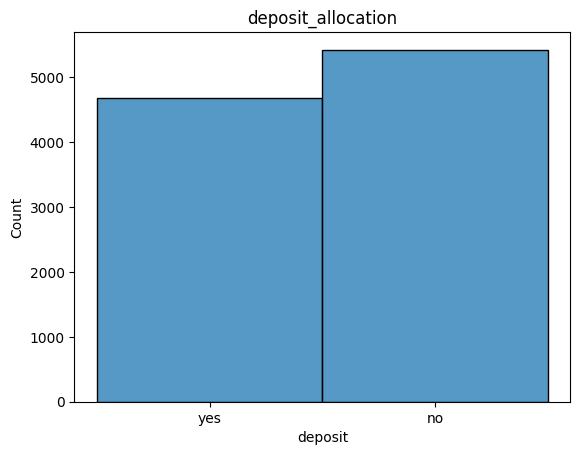

In [1010]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
opened = df[df['deposit']=='yes'].shape[0]
not_opened = df[df['deposit']=='no'].shape[0]
print(f'Amount of people who opened deposit: {opened}')
print(f"Amount of people who didn't open deposit: {not_opened}")
deposit_allocation = sns.histplot(df['deposit'])
deposit_allocation.set(title='deposit_allocation')
plt.show()

### Задания 2 и 3

In [1011]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код

print(df['age'].max())
print(df['duration'].min())


95
2


### Задания 4 и 5

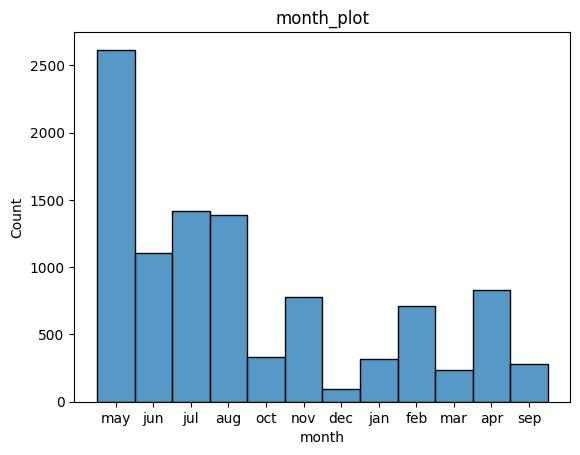

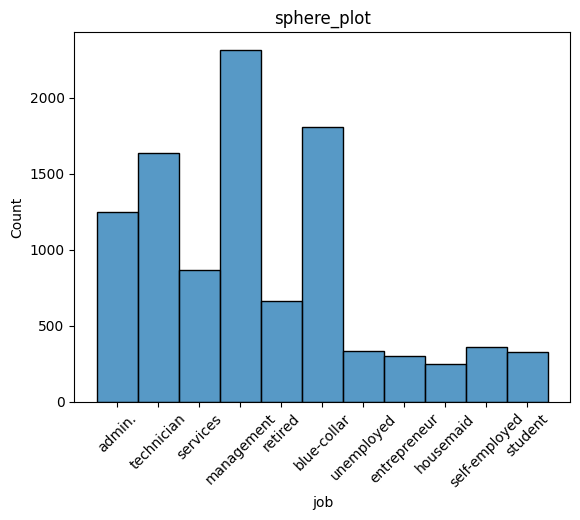

In [1012]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

month_plot = sns.histplot(df['month'])
month_plot.set(title='month_plot')
plt.show()
sphere_plot = sns.histplot(df['job'])
sphere_plot.set(title='sphere_plot')
plt.xticks(rotation=45)
plt.show()

### Задание 6

<Axes: xlabel='deposit', ylabel='Count'>

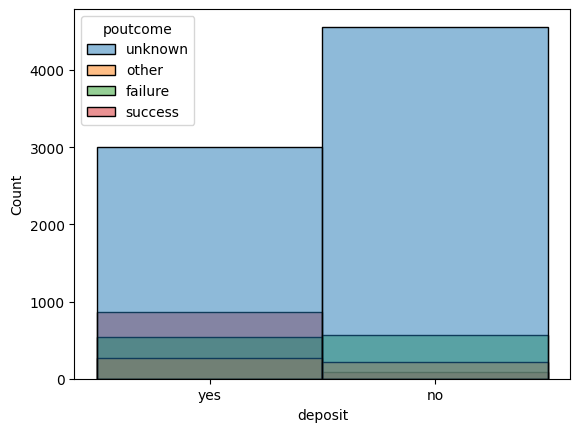

In [1013]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код

sns.histplot(data= df, hue = 'poutcome', x='deposit')

### Задание 7

In [1014]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

df[df['deposit'] == 'no']['month'].value_counts()

month
may    1776
jul     836
aug     775
jun     606
nov     456
feb     323
apr     317
jan     194
oct      62
sep      46
mar      24
dec       9
Name: count, dtype: int64

### Задание 8

In [1015]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

def age_encode(feature):
    if feature < 30:
        return '<30'
    elif feature < 41:
        return '30-40'
    elif feature < 51:
        return '40-50'
    elif feature < 61:
        return '50-60'
    else:
        return '60+'
    
df['encoded_age'] = df['age'].apply(age_encode)
    

<Axes: xlabel='encoded_age', ylabel='Count'>

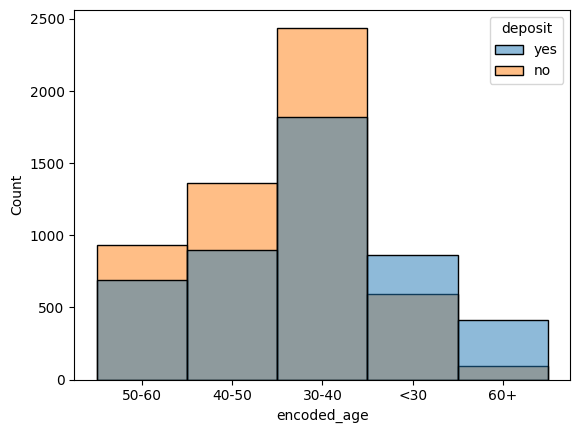

In [1016]:
sns.histplot(data = df, x='encoded_age', hue='deposit')

### Задания 9 и 10

In [1017]:
df['marital'].value_counts()

marital
married     5715
single      3213
divorced    1177
Name: count, dtype: int64

<Axes: xlabel='marital', ylabel='Count'>

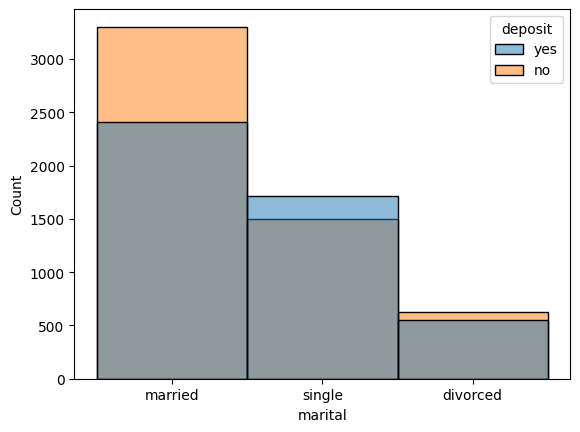

In [1018]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

sns.histplot(data=df, x='marital', hue='deposit')

<Axes: xlabel='education', ylabel='Count'>

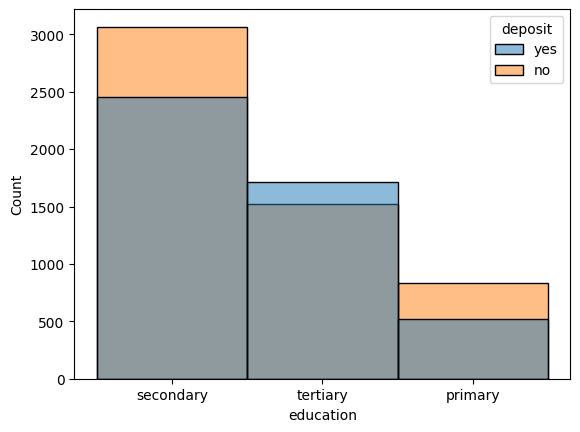

In [1019]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования


sns.histplot(data=df, x='education', hue='deposit')

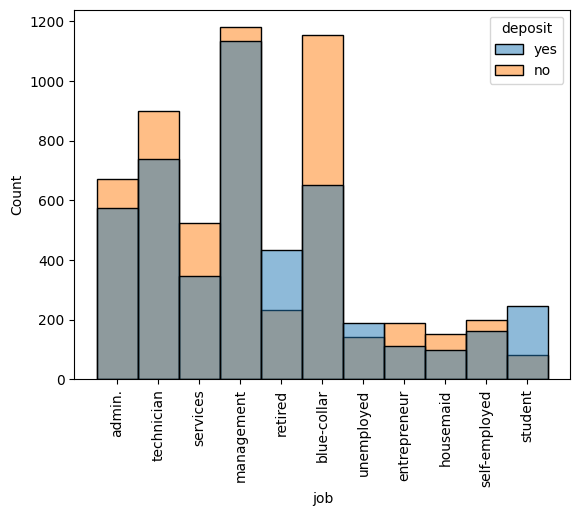

In [1020]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости


job_plot = sns.histplot(data=df, x='job', hue='deposit')
plt.xticks(rotation=90)
plt.show()

### Задание 11

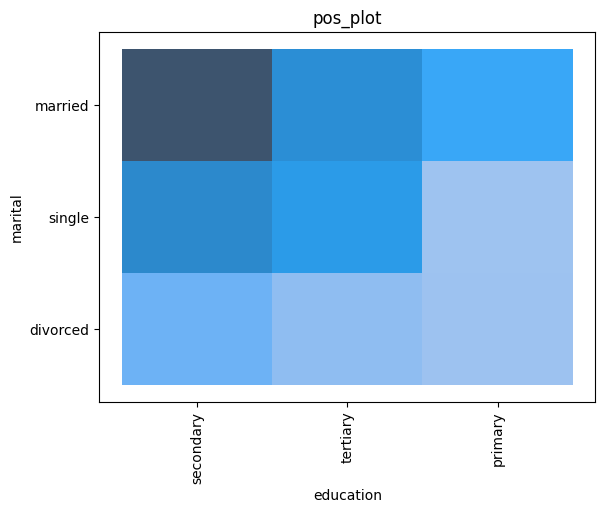

In [1021]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

positive_deposit = df[df['deposit'] == 'yes']
negative_deposit = df[df['deposit'] == 'no']
pos_plot = sns.histplot(data=df, x='education', y='marital')
pos_plot.set(title='pos_plot')
plt.xticks(rotation=90)
plt.show()

## Часть 3: преобразование данных

### Задание 1

In [1022]:
# преобразуйте уровни образования

education_label = LabelEncoder()
df['education'] = education_label.fit_transform(df['education'])
df['age_group'] = education_label.fit_transform(df['encoded_age'])
df = df.drop(['encoded_age', 'age'], axis=1)
df['education'].sum()

np.int64(11995)

### Задания 2 и 3

In [1023]:
# преобразуйте бинарные переменные в представление из нулей и единиц
binary_cat = ['deposit', 'housing', 'loan', 'default']
for cat in binary_cat:
    df[cat] = df[cat].apply(lambda x: 1 if x=='yes' else 0)
df

,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1
3,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,2
4,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,blue-collar,single,0,0,1.0,1,0,cellular,20,apr,257,1,-1,0,unknown,0,0
11158,services,married,1,0,733.0,0,0,unknown,16,jun,83,4,-1,0,unknown,0,0
11159,technician,single,1,0,29.0,0,0,cellular,19,aug,156,2,-1,0,unknown,0,0
11160,technician,married,1,0,0.0,0,1,cellular,8,may,9,2,172,5,failure,0,1


In [1024]:
df['default'].mean() + df['housing'].mean() + df['loan'].mean()

np.float64(0.6354280059376547)

### Задание 4

In [1025]:
# создайте дамми-переменные
dummies = pd.get_dummies(df[['job',
        'marital',
        'contact',
        'month',
        'poutcome']], drop_first=False)
df = pd.concat([df, dummies], axis=1)
df

,job,marital,education,default,balance,housing,loan,contact,day,month,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,admin.,married,1,0,2343.0,1,0,unknown,5,may,...,False,False,True,False,False,False,False,False,False,True
1,admin.,married,1,0,45.0,0,0,unknown,5,may,...,False,False,True,False,False,False,False,False,False,True
2,technician,married,1,0,1270.0,1,0,unknown,5,may,...,False,False,True,False,False,False,False,False,False,True
3,services,married,1,0,2476.0,1,0,unknown,5,may,...,False,False,True,False,False,False,False,False,False,True
4,admin.,married,2,0,184.0,0,0,unknown,5,may,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,blue-collar,single,0,0,1.0,1,0,cellular,20,apr,...,False,False,False,False,False,False,False,False,False,True
11158,services,married,1,0,733.0,0,0,unknown,16,jun,...,True,False,False,False,False,False,False,False,False,True
11159,technician,single,1,0,29.0,0,0,cellular,19,aug,...,False,False,False,False,False,False,False,False,False,True
11160,technician,married,1,0,0.0,0,1,cellular,8,may,...,False,False,True,False,False,False,True,False,False,False


### Задания 5 и 6

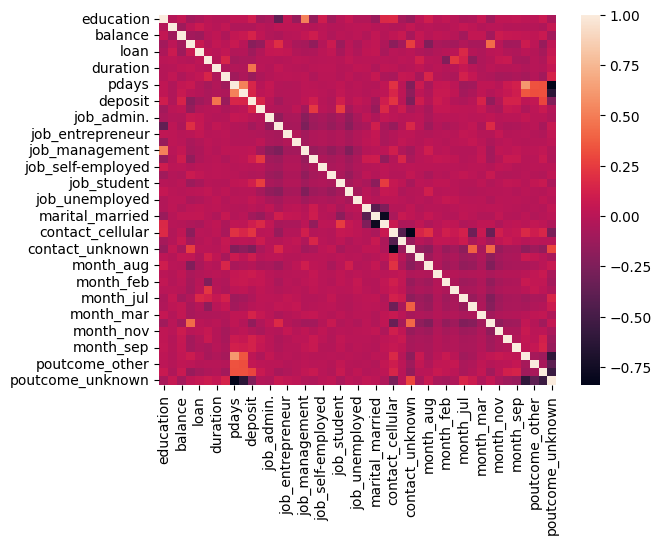

education            0.098253
default             -0.038872
balance              0.135893
housing             -0.200290
loan                -0.107240
day                 -0.056878
duration             0.457818
campaign            -0.130707
pdays                0.147917
previous             0.141102
deposit              1.000000
age_group            0.141776
job_admin.          -0.001927
job_blue-collar     -0.095845
job_entrepreneur    -0.032706
job_housemaid       -0.022572
job_management       0.029566
job_retired          0.100090
job_self-employed   -0.005194
job_services        -0.040433
job_student          0.105563
job_technician      -0.011190
job_unemployed       0.039196
marital_divorced     0.004808
marital_married     -0.094246
marital_single       0.097005
contact_cellular     0.223944
contact_telephone    0.007064
contact_unknown     -0.249294
month_apr            0.092888
month_aug           -0.018225
month_dec            0.085041
month_feb            0.044728
month_jan 

In [1026]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
sns.heatmap(df.corr(numeric_only=True))
plt.show()
df.corr(numeric_only=True)['deposit']

### Задания 7 и 8

In [1027]:
df = df.drop(['job',
        'marital',
        'contact',
        'month',
        'poutcome'], axis=1)
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [1028]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   education          10105 non-null  int64  
 1   default            10105 non-null  int64  
 2   balance            10105 non-null  float64
 3   housing            10105 non-null  int64  
 4   loan               10105 non-null  int64  
 5   day                10105 non-null  int64  
 6   duration           10105 non-null  int64  
 7   campaign           10105 non-null  int64  
 8   pdays              10105 non-null  int64  
 9   previous           10105 non-null  int64  
 10  deposit            10105 non-null  int64  
 11  age_group          10105 non-null  int64  
 12  job_admin.         10105 non-null  bool   
 13  job_blue-collar    10105 non-null  bool   
 14  job_entrepreneur   10105 non-null  bool   
 15  job_housemaid      10105 non-null  bool   
 16  job_management     10105 no

In [1029]:
# рассчитайте необходимые показатели
print(X_test.shape[0])
print(round(y_test.mean(), 2))

3335
0.46


### Задание 9

In [1030]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
# Выбор k лучших признаков (например, k=2)
selector = SelectKBest(score_func=f_classif, k=15)
X_selected = selector.fit_transform(X_train, y_train)
# Маска выбранных признаков
selected_mask = selector.get_support()

# Названия выбранных признаков
selected_features = X_train.columns[selected_mask].tolist()
print("Важные признаки:", selected_features)

Важные признаки: ['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous', 'age_group', 'contact_cellular', 'contact_unknown', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown']


In [1031]:
selected_features == ['balance', 'housing', 'duration', 'campaign', 'pdays', 
'previous', 'age_group', 'contact_cellular', 'contact_unknown',
'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown']

True

### Задание 10

In [1032]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)
round((X_test_transformed[:, 0]).mean(), 2)

np.float64(0.47)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [1033]:
# обучите логистическую регрессию и рассчитайте метрики качества
base_model = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
base_model.fit(X_train_transformed, y_train)
y_pred = base_model.predict(X_test_transformed)
y_train_pred = base_model.predict(X_train_transformed)
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.83      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.83      0.82      6770

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.81      0.81      3335



### Задания 2,3,4

In [1034]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=9)
dt.fit(X_train_transformed, y_train)
y_pred = dt.predict(X_test_transformed)
y_train_pred = dt.predict(X_train_transformed)
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      3634
           1       0.83      0.85      0.84      3136

    accuracy                           0.85      6770
   macro avg       0.85      0.85      0.85      6770
weighted avg       0.85      0.85      0.85      6770

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1790
           1       0.79      0.80      0.79      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



In [1035]:
def optuna_dt(trial):
  # задаем пространства поиска гиперпараметров
  max_depth = trial.suggest_int('max_depth', 2, 10, step=1)
  

  # создаем модель
  model = tree.DecisionTreeClassifier(random_state=42, max_depth=max_depth)

   # применим  cross validation с тем же количеством фолдов
  score = model_selection.cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_dt, n_trials=20)

print("Наилучшие значения гиперпараметров {}".format(study.best_params))

[I 2025-02-07 15:34:42,070] A new study created in memory with name: LogisticRegression
[I 2025-02-07 15:34:46,430] Trial 0 finished with value: 0.6829150318437807 and parameters: {'max_depth': 2}. Best is trial 0 with value: 0.6829150318437807.
[I 2025-02-07 15:34:47,330] Trial 1 finished with value: 0.7103464621176224 and parameters: {'max_depth': 6}. Best is trial 1 with value: 0.7103464621176224.
[I 2025-02-07 15:34:48,174] Trial 2 finished with value: 0.743589528919496 and parameters: {'max_depth': 7}. Best is trial 2 with value: 0.743589528919496.
[I 2025-02-07 15:34:48,245] Trial 3 finished with value: 0.7438014407145486 and parameters: {'max_depth': 5}. Best is trial 3 with value: 0.7438014407145486.
[I 2025-02-07 15:34:48,324] Trial 4 finished with value: 0.7461059109694658 and parameters: {'max_depth': 9}. Best is trial 4 with value: 0.7461059109694658.
[I 2025-02-07 15:34:48,391] Trial 5 finished with value: 0.7103464621176224 and parameters: {'max_depth': 6}. Best is trial 

Наилучшие значения гиперпараметров {'max_depth': 9}


### Задание 5

In [1043]:
# подберите оптимальные параметры с помощью gridsearch
grid = {'min_samples_split': [2, 5, 7, 10],
        'max_depth':[3,5,7]
}

grid_search = model_selection.GridSearchCV(estimator=tree.DecisionTreeClassifier(random_state=42), param_grid=grid, n_jobs=-1)

grid_search.fit(X_train_transformed, y_train)

y_pred = grid_search.predict(X_test_transformed)

print(f'f-1 = {metrics.f1_score(y_test, y_pred)}')

f-1 = 0.8010236724248241


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [1046]:
# обучите на ваших данных случайный лес

rf = ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_leaf=5, max_depth=10, random_state=42)
rf.fit(X_train_transformed, y_train)
y_pred = rf.predict(X_test_transformed)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [1047]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
rfb = ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, min_samples_leaf=5, max_depth=5, random_state=42)
rfb.fit(X_train_transformed, y_train)
y_pred = rfb.predict(X_test_transformed)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



### Задание 4

In [1048]:
# объедините уже известные вам алгоритмы с помощью стекинга 

stack = ensemble.StackingClassifier(estimators=[('dt', dt), ('lr', base_model), ('rfb', rfb)], final_estimator=linear_model.LogisticRegression(random_state=42))
stack.fit(X_train_transformed, y_train)
y_pred = stack.predict(X_test_transformed)


In [1049]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

In [1060]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
features = pd.DataFrame(selected_features, columns=['features'])
data = pd.concat([features, pd.DataFrame(rfb.feature_importances_, columns=['importance'])], axis=1)

In [1062]:
data.sort_values(by='importance')

,features,importance
14,poutcome_unknown,0.001403
7,contact_cellular,0.004497
5,previous,0.008046
12,month_sep,0.013232
10,month_may,0.014919
3,campaign,0.015044
11,month_oct,0.019705
9,month_mar,0.027155
6,age_group,0.042998
1,housing,0.047964


### Задания 6,7,8

In [1064]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

def optuna_boost(trial):
  # задаем пространства поиска гиперпараметров
    
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  

  # создаем модель
    model = ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_depth=max_depth, random_state=42)

   # применим  cross validation с тем же количеством фолдов
    score = model_selection.cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

    return score

study = optuna.create_study(study_name="gradient boost", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_boost, n_trials=20)

print("Наилучшие значения гиперпараметров {}".format(study.best_params))

[I 2025-02-08 00:32:20,829] A new study created in memory with name: gradient boost


[I 2025-02-08 00:33:13,063] Trial 0 finished with value: 0.774837413176637 and parameters: {'n_estimators': 186, 'max_depth': 25, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.774837413176637.
[I 2025-02-08 00:33:35,294] Trial 1 finished with value: 0.7853693376237221 and parameters: {'n_estimators': 166, 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.7853693376237221.
[I 2025-02-08 00:33:45,789] Trial 2 finished with value: 0.7928581009795047 and parameters: {'n_estimators': 119, 'max_depth': 13, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.7928581009795047.
[I 2025-02-08 00:34:20,955] Trial 3 finished with value: 0.7905391968170654 and parameters: {'n_estimators': 199, 'max_depth': 29, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.7928581009795047.
[I 2025-02-08 00:34:40,795] Trial 4 finished with value: 0.7803882788693917 and parameters: {'n_estimators': 113, 'max_depth': 29, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.79285

Наилучшие значения гиперпараметров {'n_estimators': 132, 'max_depth': 10, 'min_samples_leaf': 7}


{'n_estimators': 132, 'max_depth': 10, 'min_samples_leaf': 7}

In [1070]:
model = ensemble.GradientBoostingClassifier(**study.best_params, learning_rate=0.05, random_state=42)
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_test_transformed)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.79      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



In [1071]:
model = ensemble.GradientBoostingClassifier(n_estimators = 132, max_depth = 10, min_samples_leaf = 7, learning_rate=0.05, random_state=42)
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_test_transformed)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.79      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

